# Step A - Multiple Product Detection:
Develop an object detection system to identify single instance of products given: one reference image for
each item and a scene image. The system should be able to correctly identify all the product in the shelves
image. One way to solve this task could be the use of local invariant feature as explained in lab session 5.

### Source
https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os   

In [2]:
#convinience function
path_models = os.path.join("product-recognition-on-store-shelves-images","object_detection_project","models")
path_scenes = os.path.join("product-recognition-on-store-shelves-images","object_detection_project","scenes")

def get_path_model(index):
    return os.path.join(path_models, f"{index}.jpg")

def get_path_scene(index):
    return os.path.join(path_scenes, f"{index}")

In [3]:
#drawing functions

def plot_images(image_paths):

    images = [cv.imread(p) for p in image_paths]

    # Check if the list is empty
    if not images:
        raise ValueError("The list of images is empty.")
    
    # Find the maximum height among all images
    max_height = max(img.shape[0] for img in images)
    
    # Resize all images to have the same height
    resized_images = [
        cv.resize(img, (int(img.shape[1] * max_height / img.shape[0]), max_height))
        for img in images
    ]
    
    # Horizontally concatenate images
    concatenated_image = np.hstack(resized_images)
    print([os.path.split(p)[-1] for p in image_paths])
    plt.imshow(cv.cvtColor(concatenated_image, cv.COLOR_BGR2RGB))
    plt.title("models")
    plt.show()

def draw_good_and_bad_matches(scene, good, bad, kp_scene):
#draw excluded and included matches
        for o in bad:
            x,y = kp_scene[o.trainIdx].pt
            coord = [int(x), int(y)]
            cv.circle(scene, coord, 3, (0,0,255), 2)

        for o in good:
            x,y = kp_scene[o.trainIdx].pt  # Get match coordinates
            coord = [int(x), int(y)]
            cv.circle(scene, coord, 3, (0,255,0), 2)

        plt.imshow(cv.cvtColor(scene, cv.COLOR_BGR2RGB))
        plt.title("good and bad (excluded) matches")
        plt.show()

def draw_matches(model, kp_model, scene, kp_scene, good):
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                        singlePointColor = None, # not draw keypoints only matching lines
                        flags = 2) # not draw keypoints only lines
    image = cv.drawMatches(model, kp_model, scene, kp_scene, good, None,**draw_params)
    plt.title("Matched keypoints")
    plt.imshow(image)
    plt.show()

In [16]:
def find_image(scene_path, model_paths, plot_diagrams=False):

    if plot_diagrams:
        plot_images(model_paths)
    target_resolution = (150, 210)
    scene_gray = cv.imread(scene_path,cv.IMREAD_GRAYSCALE)

    scene_to_draw_on = cv.imread(scene_path)

    #create array with all models
    models = []
    for model_gray_path in model_paths:
        
        name = os.path.split(model_gray_path)[-1]
        models.append({
            "name": name,
            "img": cv.imread(model_gray_path, cv.IMREAD_GRAYSCALE)
            })
        
    # find smallest image #TODO adjust MIN_MATCH_COUNT parameter to work with this
    common_height = np.max([o["img"].shape[0] for o in models])


    for model in models:
        print(f"Looking for {model["name"]}...")

        model_gray = model["img"]
        ratio = common_height/model_gray.shape[0]
        new_w = model_gray.shape[1]*ratio
        model_gray = cv.resize(model_gray, (int(new_w), common_height), interpolation=cv.INTER_AREA)
        MIN_MATCH_COUNT = 150

        # Initiate SIFT detector
        sift = cv.SIFT_create()

        # find the keypoints and descriptors with SIFT
        kp_model, des_model = sift.detectAndCompute(model_gray,None)
        kp_scene, des_scene = sift.detectAndCompute(scene_gray,None)

        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des_model,des_scene,k=2)

        # store all the good matches as per Lowe's ratio test.
        good = []
        bad = []
        for m,n in matches:
            if m.distance < 0.7 * n.distance:
                good.append(m)
            else:
                bad.append(m)
                
        if plot_diagrams:
            draw_good_and_bad_matches(scene_to_draw_on, good, bad, kp_scene)
            draw_matches(model_gray, kp_model, scene_gray, kp_scene, good)
            
        scene_to_draw_on = scene_to_draw_on if scene_to_draw_on is not None else scene_gray

        result = scene_to_draw_on
        
        if len(good)>MIN_MATCH_COUNT:
            print( "Enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
            src_pts = np.float32([ kp_model[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp_scene[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
            M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
            h,w = model_gray.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            
            dst = cv.perspectiveTransform(pts,M)

            #add square and add text
            means = np.mean(dst, axis=0)
            x, y = [a for a in means[0]]
            x = x * 0.8 #adjust for text
            
            result = cv.polylines(scene_to_draw_on,[np.int32(dst)],True,255,3, cv.LINE_AA)

            boldness = 3
            size = 3
            cv.putText(scene_to_draw_on, model["name"], (int(x),int(y)), cv.FONT_HERSHEY_COMPLEX_SMALL, size, (0, 0, 255, 255), boldness, cv.LINE_AA)
        
        else:
            print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )

    print("------------------------------------------")
    print("Results:")
    return result

Looking for 0.jpg...
Enough matches are found - 463/150
Looking for 1.jpg...
Enough matches are found - 174/150
Looking for 11.jpg...
Enough matches are found - 235/150
Looking for 19.jpg...
Not enough matches are found - 47/150
Looking for 24.jpg...
Not enough matches are found - 66/150
Looking for 26.jpg...
Enough matches are found - 193/150
Looking for 25.jpg...
Not enough matches are found - 40/150
------------------------------------------
Results:


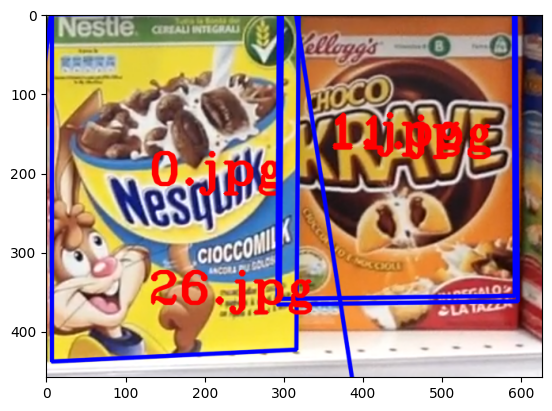

In [17]:
#define models to be searched in image
models = [get_path_model(a) for a in [0, 1, 11, 19, 24, 26, 25]]

result = find_image(scene_path=get_path_scene("e1.png"),
                    model_paths=models
                    )

plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()

Looking for 0.jpg...
Enough matches are found - 197/150
Looking for 1.jpg...
Not enough matches are found - 91/150
Looking for 11.jpg...
Not enough matches are found - 150/150
Looking for 19.jpg...
Not enough matches are found - 52/150
Looking for 24.jpg...
Enough matches are found - 367/150
Looking for 26.jpg...
Enough matches are found - 387/150
Looking for 25.jpg...
Enough matches are found - 241/150
------------------------------------------
Results:


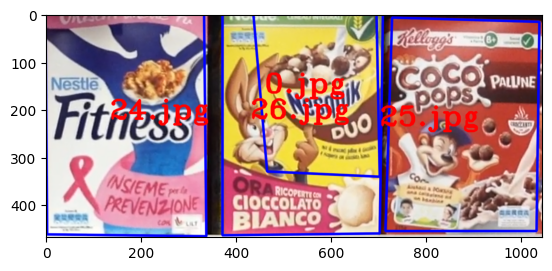

In [18]:
result = find_image(scene_path=get_path_scene("e2.png"),
                    model_paths=models
                    )

plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()

['0.jpg', '1.jpg', '11.jpg', '19.jpg', '24.jpg', '26.jpg', '25.jpg']


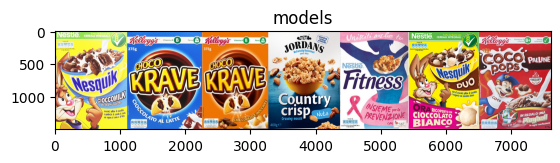

Looking for 0.jpg...


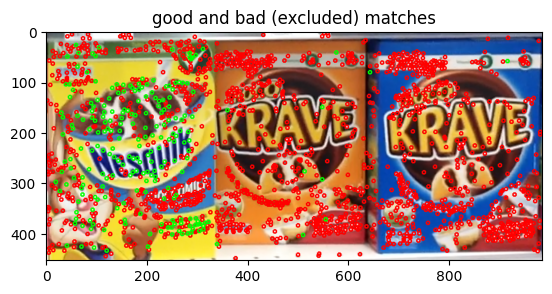

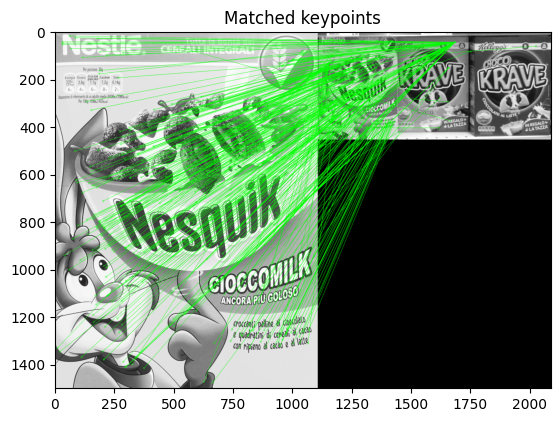

Enough matches are found - 385/150
Looking for 1.jpg...


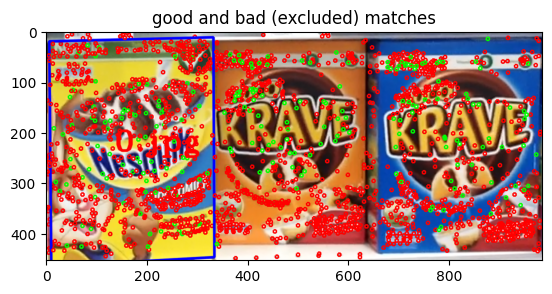

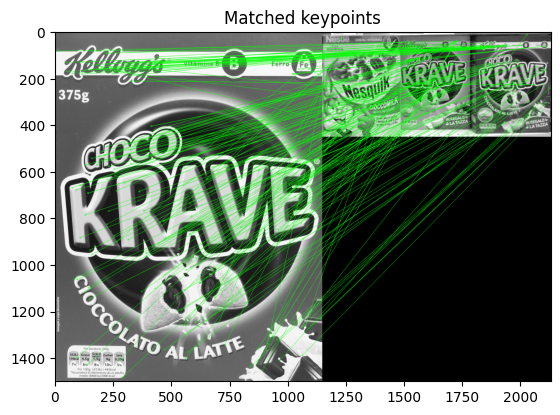

Enough matches are found - 193/150
Looking for 11.jpg...


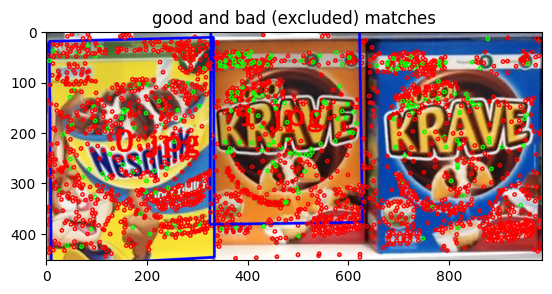

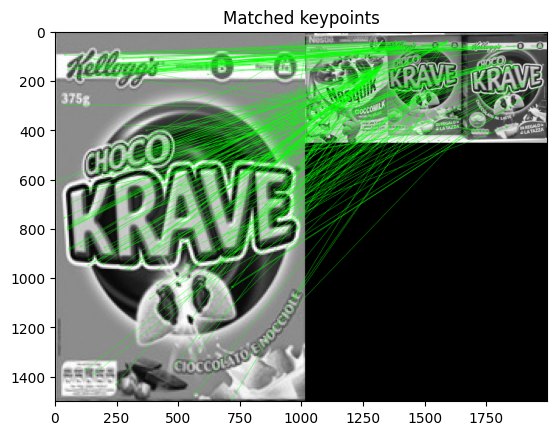

Enough matches are found - 235/150
Looking for 19.jpg...


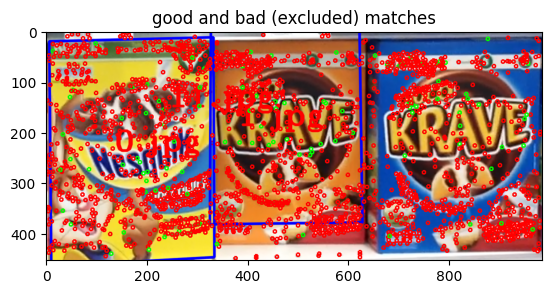

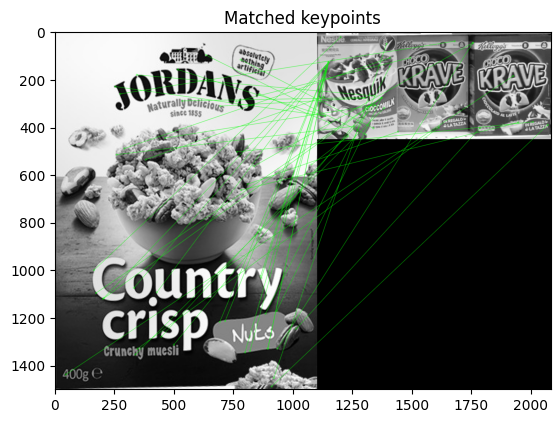

Not enough matches are found - 44/150
Looking for 24.jpg...


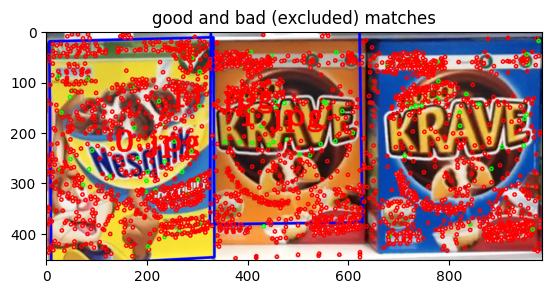

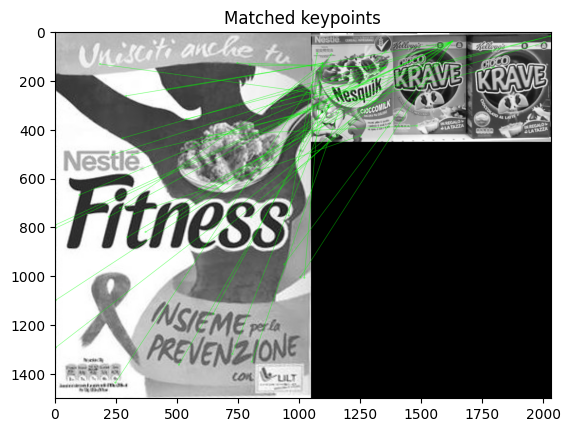

Not enough matches are found - 42/150
Looking for 26.jpg...


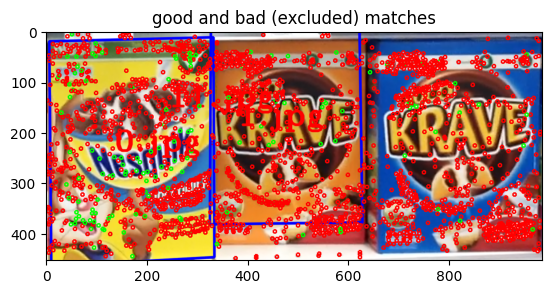

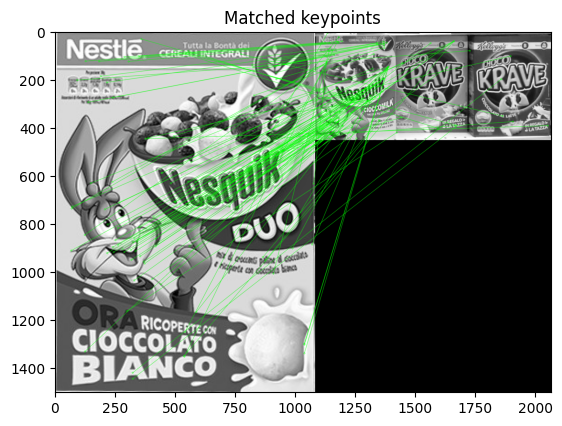

Not enough matches are found - 124/150
Looking for 25.jpg...


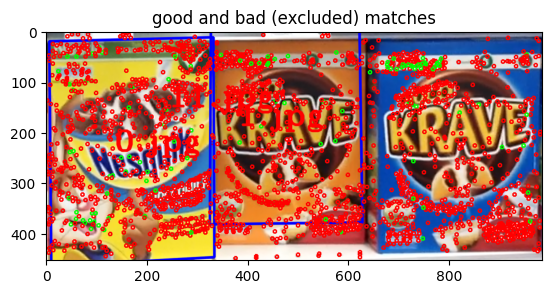

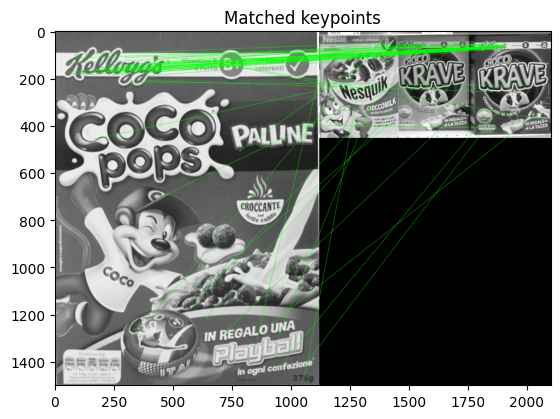

Not enough matches are found - 58/150
------------------------------------------
Results:


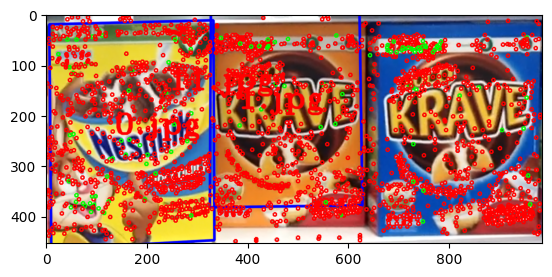

In [19]:
result = find_image(scene_path=get_path_scene("e3.png"),
                    model_paths=models,
                    plot_diagrams=True
                    )

plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()

Looking for 0.jpg...
Enough matches are found - 210/30
Looking for 1.jpg...
Enough matches are found - 140/30
Looking for 11.jpg...
Enough matches are found - 112/30
Looking for 19.jpg...
Not enough matches are found - 5/30
Looking for 24.jpg...
Not enough matches are found - 5/30
Looking for 26.jpg...
Enough matches are found - 244/30
Looking for 25.jpg...
Enough matches are found - 165/30
------------------------------------------
Results:


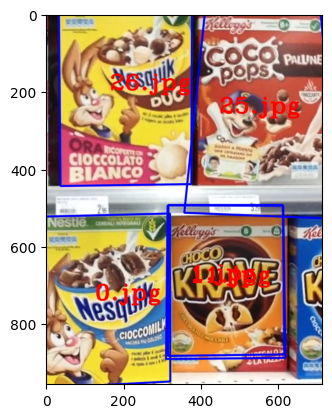

In [8]:
result = find_image(scene_path=get_path_scene("e4.png"),
                    model_paths=models
                    )

plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()

Looking for 0.jpg...
Not enough matches are found - 0/30
Looking for 1.jpg...
Not enough matches are found - 28/30
Looking for 11.jpg...
Not enough matches are found - 10/30
Looking for 19.jpg...
Enough matches are found - 201/30
Looking for 24.jpg...
Not enough matches are found - 6/30
Looking for 26.jpg...
Not enough matches are found - 2/30
Looking for 25.jpg...
Enough matches are found - 174/30
------------------------------------------
Results:


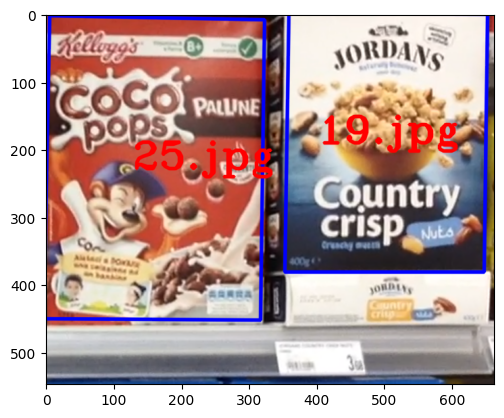

In [9]:
result = find_image(scene_path=get_path_scene("e5.png"),
                    model_paths=models
                    )

plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()